# Convolutional Neural Networks tutorial

*********************


In this tutorial you will build your first Convolutional Neural Network (CNN) to distinguish pictures containing dogs from others containing cats.

It is organized into six parts, covering the following topics:


1.   Data Preprocessing
2.   Model Building and Training
3.   Performances Visualization and Interpretation
4.   Model Improvements
5.  Opening the black box (filters and features visualization)
6.   Data augmentation


The dogs vs cats dataset refers to a dataset used for a Kaggle machine learning competition held in 2013 (https://www.kaggle.com/c/dogs-vs-cats/data).

The Kaggle competition provided 25000 labeled RGB photos: 12500 dogs and the same number of cats.
The dataset is straightforward to understand and not so big to fit into memory, therefore it has become a good “hello world” or “getting started” computer vision dataset for CNN beginners.




****************
In order to avoid you to download the dataset (~935MB) we already downloaded and shared it in a google drive folder.
In this way you can directly access to it, by following these few passages:

  *   **create a folder in your Drive where to work in this tutorial** (called in the following code "CNN_dataset", but you can change the name)
  *   **open the google Drive link https://drive.google.com/drive/folders/19uC8Nr4RPHzUkSY69ElaZNB27PO84l5p?usp=sharing right click on the folder "Dogs vs Cats" selecting "add a shortcut to MyDrive" and choose the folder just created.**
  *   this folder will be your local directory where to preprocess data. **IMPORTANT: the shortcut is not a copy but a link to the original dataset. Please make sure to not modify the dataset!!!**


First you have to import the Google Drive as external disk on Colab

In [44]:
'''
#mount Drive as external disk
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
'''

"\n#mount Drive as external disk\nfrom google.colab import drive\ndrive.mount('/content/drive', force_remount=True)\n"

In [45]:
'''
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
'''

"\ngpu_info = !nvidia-smi\ngpu_info = '\n'.join(gpu_info)\nif gpu_info.find('failed') >= 0:\n  print('Not connected to a GPU')\nelse:\n  print(gpu_info)\n"

Now we can move to the first part of the tutorial.

# 1) Data Preprocessing

Let's first import few libraries we need:

In [46]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from os import listdir
import os, glob,sys
from matplotlib import pyplot
from matplotlib.image import imread
import numpy as np

import keras
import random
from keras import backend as K

Let's have a look now into the dataset folder.
The dataset is organized into three subfolders: train, test and validation.

In [47]:
# absolute_path = '/content/drive/My Drive/Didattica/Corsi/AI/Lectures/Lecture5/CNN example/data/' #your path on google drive. It should start with /content/drive/My Drive/ and then the name of your folder "MyFolder" to modify.
absolute_path = './images/'
dataset_path = absolute_path + 'Dogs-Vs-Cats/'

In [48]:
folders = listdir(dataset_path)
for folder in folders:

  print(folder)
  #let's look at the organization inside the folders
  if os.path.isdir(dataset_path + folder):
     print(listdir(dataset_path + folder))
    #and count how many pictures are in each folder
    #print(len(listdir(dataset_path + folder+ '/dogs')))
    #print(len(listdir(dataset_path + folder+ '/cats')))

     #also glob could be used
     print(len(glob.glob(dataset_path + folder+ '/dogs/*')))
     print(len(glob.glob(dataset_path + folder+ '/cats/*')))
     print('')

best_model.h5
.DS_Store
test
['dogs', 'cats', '.DS_Store']
1250
1250

train
['dogs', 'cats', '.DS_Store']
8383
8492

validation
['dogs', 'cats', '.DS_Store']
2867
2758

numpys
['dogs_vs_cats_photos_test.npy', 'dogs_vs_cats_labels_train.npy', 'dogs_vs_cats_labels_validation.npy', 'dogs_vs_cats_photos_train.npy', 'my_model.h5', 'dogs_vs_cats_labels_test.npy', 'dogs_vs_cats_photos_validation.npy']
0
0




Let's visualize the first 4 cats and 4 dogs in the training dataset.\
**Can you do them?**


The simplest approach:



*   Take a photo path
*   Plot it



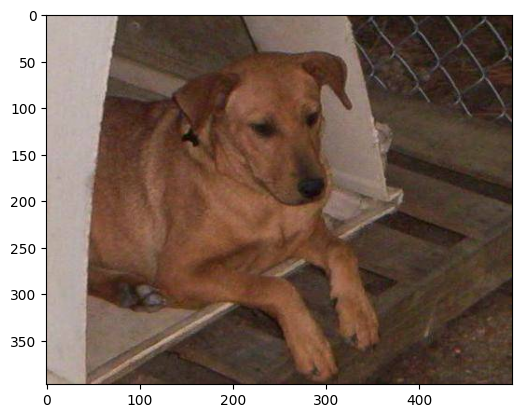

In [49]:

img_path = dataset_path + '/train/dogs/dog.100.jpg'
image = imread(img_path)
pyplot.imshow(image)


A function to get real image dimension

In [50]:
from PIL import Image

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    print ('Width: ', width, 'Height:', height)

get_num_pixels(img_path)

Width:  500 Height: 397


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

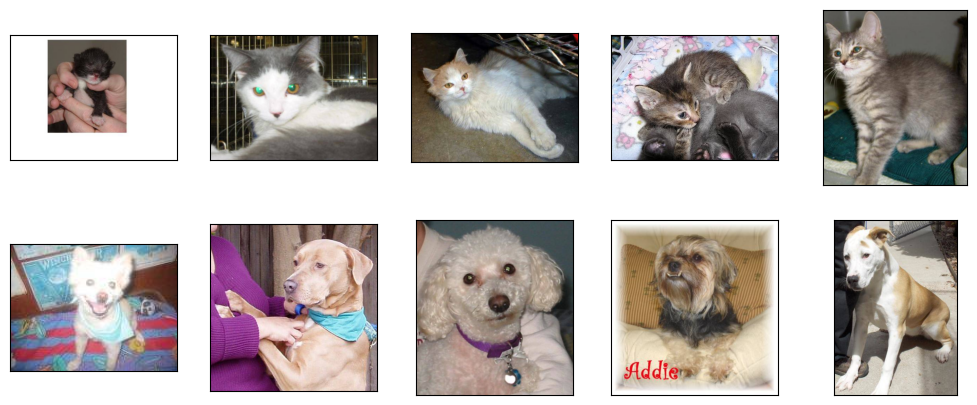

In [51]:
def list_full_paths(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory)]

#Here we define a plotting function
def show_images(imgs, num_rows, num_cols, titles=None, scale=2.5):

    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = pyplot.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):

        image = imread(img)
        ax.imshow(image)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

#Here we create our dataset
N = 5
imgs = np.concatenate((list_full_paths(dataset_path + 'train/cats/')[:N],
                      list_full_paths(dataset_path + 'train/dogs/')[:N]) )
show_images(imgs, 2, N)


## Preparing dataset


Since we are running on Colab and we have limited resources, we are going to reduce the image size to 64x64 pixels.\
In the following cells we will loop over all images, reducing their dimension and then convert each image to a numpy array.\
We also create the array with labels (**1 for dog and 0 for cat**).\
Finally we will save all pictures and labels inside two different .numpy files.


In [52]:

from os import makedirs
from shutil import copyfile
#from random import seed
#from random import random
from numpy import asarray
from numpy import save, random

reduced_size = (64, 64) #reduced image size for avoiding  memory problems

#create the directory for numpy files with resized pictures (not inside the original dataset folder!)
npy_folder = absolute_path + 'Dogs-Vs-Cats/numpys/' #CNN_dataset is the name of your folder. To modify!

If you already created your numpy directory, you can skip this cell. (It will take ~10 minutes)

In [53]:
from tqdm import tqdm

if os.path.isdir(npy_folder):
  print(npy_folder + ' already exists')
else:
  print('Creating numpy dir at ', npy_folder)
  makedirs(npy_folder, exist_ok=True)


  for folder in listdir(dataset_path): #look at the folders names
    print(folder)
    if folder=='numpys': #reduntant control to skip eventual numpys folder wrongly created inside the dataset path
      continue
    path_folder = dataset_path + folder

    #now we have to create numpys with pictures and labels (1 for dogs and 0 for cats)
    photos, labels = list(), list()
    labelList = listdir(path_folder)

    for folder_label in labelList: #enter inside train, test, validation
      print("|_",folder_label)

      path_files = path_folder + '/' + folder_label
      fileList = listdir(path_files)

      for file_ in tqdm(fileList): #read the images

        output = 0.0
        if file_.startswith('dog'):
          output = 1.0
        photo = load_img(path_files + '/' + file_, target_size=reduced_size) #load image
        photo = img_to_array(photo) #convert to numpy array

        photos.append(photo)
        labels.append(output)

    #convert to a numpy arrays
    photos = asarray(photos)
    labels = asarray(labels)
    print(photos.shape, labels.shape)

    #random shuffle for dogs and cats vector
    seed=10
    random.seed(seed)
    random.shuffle(photos)
    random.seed(seed)
    random.shuffle(labels)
    #print(photos.shape, labels.shape)

    # save the reshaped photos
    save(npy_folder + 'dogs_vs_cats_photos_' + folder + '.npy', photos, allow_pickle=True)
    save(npy_folder + 'dogs_vs_cats_labels_' + folder + '.npy', labels, allow_pickle=True)
    print(folder, ' created and filled')

./images/Dogs-Vs-Cats/numpys/ already exists


Let's retrieve our numpy arrays and create training and validation datasets.

In [54]:
# load the dataset
from numpy import load


if not os.path.isdir(npy_folder): raise RuntimeError('Path not found!', npy_folder)

print('Training photos and their labels')
photos_train = load(npy_folder + 'dogs_vs_cats_photos_train.npy', allow_pickle=True)
labels_train = load(npy_folder + 'dogs_vs_cats_labels_train.npy', allow_pickle=True)

print(photos_train.shape, labels_train.shape)

print('Validation photos and their labels')
photos_validation = load(npy_folder + 'dogs_vs_cats_photos_validation.npy', allow_pickle=True)
labels_validation = load(npy_folder + 'dogs_vs_cats_labels_validation.npy', allow_pickle=True)

print(photos_validation.shape, labels_validation.shape)


Training photos and their labels
(16875, 64, 64, 3) (16875,)
Validation photos and their labels
(5625, 64, 64, 3) (5625,)


**Are labels correctly associated to the pictures? Let's print some images and corrresponding labels**

[0. 1. 1. 1. 1. 1. 1. 1. 1.]


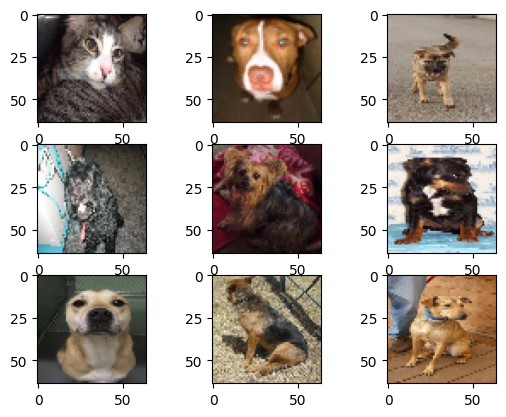

In [55]:
#show few photos from the training dataset
N = 9
print(labels_train[:N])

# plot first N photos in training dataset
for i in range(N):
  # define subplot
  pyplot.subplot(330 + 1 + i)

  #plot raw pixel data
  pyplot.imshow((photos_train[i]).astype(np.uint8))


# show the figure
pyplot.show()

#2) Model building and training

Now let's import some libraries for our model building:

In [56]:

from matplotlib import pyplot

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout


from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import binary_crossentropy,BinaryCrossentropy



## Model definition

Now we are ready to create our CNN model.\
Let's insert two  Convolutional layers, respectively with 6 and 12 3x3 filters, followed by two MaxPooling layers 2x2.\
We use a zero padding 'same', meaning that the number of zero pixels inserted in each spatial direction is automatically calculated in order to preserve the spatial size of the input image (in this case 64x64).\
The activation function adopted for convolutional layers is the ReLU, one of the most used in DNN and CNN to insert non linearity in the model.\
After the convolutions the output is reshaped (flattened) and fed to two dense layers.\
The activation for the final output is the Sigmoid function: it returns a value between 0 and 1 and means the probability for the image to belong to class 1.\
The (mini-batch) stochastic gradient descent is used here for weights updating (https://keras.io/api/optimizers/sgd/). By setting the momentum!=0 weights are updated in this folloing way:

~~~~~~~~~~~~
velocity = momentum * velocity - learning_rate * g
w = w + velocity
~~~~~~~~~~~~~


In [66]:
#create the CNN model

def define_model(initial_input_shape):

  model = Sequential()
  model.add(Conv2D(6, (3, 3), activation='relu',  padding='same', input_shape=initial_input_shape))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(12, (3, 3), activation='relu',  padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten(name='flatten_layer')) #now we flat the maxpooling output to match the fully connected Dense layer input
  layer = model.get_layer('flatten_layer')

  model.add(Dense(layer.output.shape[1], activation='relu'))

  model.add(Dense(1, activation='sigmoid'))

  opt = SGD(learning_rate=0.001, momentum=0.9) #SGD is the stochastic gradient descent

  model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy']) #now compile the model with all the ingredients
  model.summary()

  return model

Our goal consists in distinguish dogs from cats, therefore it is a binary classification problem.\
One of the loss functions more used for this task is the Binary Cross Entropy and the metric we adopt to monitor the training is the Accuracy.
*******************
Remember that **Binary Cross Entropy is the negative average of the log of corrected predicted probabilities**. By minimizing it we maximize the probability of correct predictions.\
\
$Binary\ Cross\ Entropy = - \frac{1}{N}\Sigma_{i=1}^{N}(y_i\cdot \log{p_i}\ +\ (1-y_i) \cdot \log{(1-p_i)}))$\
\
**The Accuracy is the fraction of correct predictions on the number of total predicions**:\
\
$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$\
\
where TP and FP mean "True Positive" and "False Positive" (class 1) and the TN and FN mean the same for "Negative" (class 0).



**********************

Let's instance our CNN by calling the just created function!

In [67]:
input_shape = np.shape(photos_train[1])
CNN = define_model(input_shape)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 64, 64, 6)      │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 32, 32, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 12)     │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3072)           │     9,440,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │         3,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,444,157 (36.03 MB)

 Trainable params: 9,444,157 (36.03 MB)

 Non-trainable params: 0 (0.00 B)

Keras models have particular functions called "Callbacks", that can be called before, during and/or after each training epoch. They may be custom functions defined in a certain way by the users but some pre-defined functions already exist.\
Here we are going to use one of the existing callbacks, the "EarlyStopping", that is a powerful tool to prevent overfitting.\
It stops the training when the validation performances do not improve after a decided number of epochs. For istance, we can decide to stop training if the validation loss does not decrease after 10 epochs.\
The value to monitor in order to stop the training can be passed as a function parameter; here we use the loss calculated on the validation dataset, but we could use the validation accuracy as well.

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
callback_ES = [EarlyStopping(verbose=True, patience=10, monitor='val_loss')]

Now it's time to perform the training with the fit method.\
The "batch_size" argument takes the number of events per batch. According to its value, there are three different gradient minimizations:

*   **Batch Gradient Descent**: we consider all the examples for every step of Gradient Descent. The batch size is equal to the datset size. The graph of cost vs epochs is also quite smooth because we are averaging over all the gradients of training data for a single step. The cost keeps on fast decreasing over the epochs, but for large dataset it is computationally expensive.
*   **Stochastic Gradient Descent**: we consider just one example at a time to take a single step. The batch size is equal to 1. The loss will fluctuate over the training examples and might never reach the minima but rather keep dancing around it. It converges faster when the dataset is large as it causes updates to the parameters more frequently.
*   **Mini-Batch Gradient Descent**: we use a batch of a fixed number of training examples which is less than the actual dataset and call it a mini-batch. Frequently used batch sizes are: 32, 64, 128, and 256.
\
Doing this helps us to achieve the advantages of both the former variants.
When we use the mini-batch gradient descent we update our parameters frequently as well as we can use vectorized implementation for faster computations.






## Training
Let's try with batch_size=64 and 50 epochs in our training, with the EarlyStopping callback.

In [60]:
# fit the model
n_epochs = 50
batch_size = 64

#Rescaling pixels between 0 and 1 (rather than 0 and 255) can help in loss implementation
rescale = 255.0

history = CNN.fit(photos_train/rescale, labels_train,
                  batch_size=batch_size,
                  validation_data=(photos_validation/rescale, labels_validation),
                  epochs=n_epochs, callbacks=callback_ES, verbose=1)
#the output is a history object that contains all information collected during training. We store it to plot network performances during training


KeyboardInterrupt: 

Let's save the just trained model in a "h5" format.
The next time we will just want to test the model we could directly load it without running the training cell.

In [ ]:
#to save the model
print('Saving model in ' + npy_folder)
CNN.save(npy_folder + 'my_model.h5')

#to open an existing model
print('Opening model in ' + npy_folder)
CNN = keras.models.load_model(npy_folder + 'my_model.h5', compile=True)
CNN.summary()


Saving model in ./images/Dogs-Vs-Cats/numpys/
Opening model in ./images/Dogs-Vs-Cats/numpys/


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 6)      │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 12)     │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3072)           │     9,440,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         3,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,444,159 (36.03 MB)

 Trainable params: 9,444,157 (36.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

#3) Performances Visualization and Interpretation
With the training History we can now plot the trend of Loss during training epochs as well as the accuracy, for both train and validation dataset.\
If the model overfitted the loss function on validation is much higher then the loss on training (and it is the opposite for accuracy), meaning that the model performes well on training but it is not able to generalize to other data.\
On the contrary, if the model is not well learnt (underfitting) also the train loss is high (and the accuracy is low).\
That's why a good way to monitor over/underfitting is to look at loss (and accuracy) trend over training epochs.

## Plotting loss

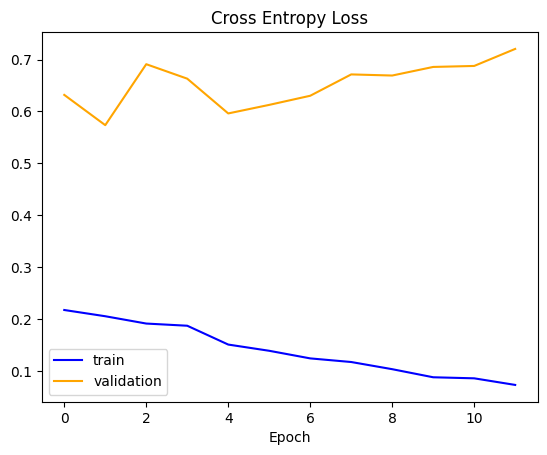

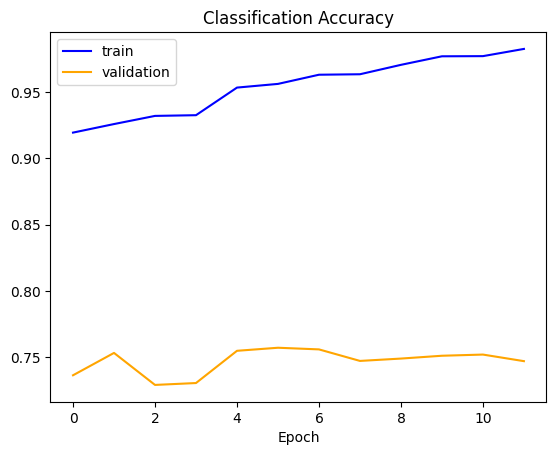

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot loss
pyplot.title('Cross Entropy Loss')
pyplot.plot(history.history['loss'], color='blue', label='train')
pyplot.plot(history.history['val_loss'], color='orange', label='validation')
pyplot.xlabel('Epoch')
pyplot.legend()
pyplot.show()
pyplot.clf()

# plot accuracy
pyplot.title('Classification Accuracy')
pyplot.plot(history.history['accuracy'], color='blue', label='train')
pyplot.plot(history.history['val_accuracy'], color='orange', label='validation')
pyplot.xlabel('Epoch')
pyplot.legend()

# save plot to file
pyplot.show()
pyplot.clf()



## Model evaluation on test dataset

Now we can evaluate the trained model on the left out test dataset.

In [ ]:
# evaluate the model on test dataset

rescale=255.
print('Opening test photos and their labels')
photos_test = load(npy_folder + 'dogs_vs_cats_photos_test.npy', allow_pickle=True)
labels_test = load(npy_folder + 'dogs_vs_cats_labels_test.npy', allow_pickle=True)

_, acc = CNN.evaluate(photos_test/rescale, labels_test, batch_size=64, verbose=1)

print('Accuracy on test dataset: %.3f' % acc)


Opening test photos and their labels
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7560 - loss: 0.7519
Accuracy on test dataset: 0.760


Let's make predictions! We will use


```
model.predict()
```




In [ ]:
#now read the model on train and test dataset and save the predictions
print ('Running model prediction on train set')
ypred_train= CNN.predict(photos_train/rescale, verbose = True, batch_size=64) #the batch_size in the predict method is only for parallelization

print ('Running model prediction on test set')
ypred_test= CNN.predict(photos_test/rescale, verbose = True, batch_size=64)


Running model prediction on train set
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Running model prediction on test set
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Can you write a function that open an image, convert it to a numpy array and predict label?

Below a simple function which load an image and predict the output




(1, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted probability for a dog: [0.9904537]


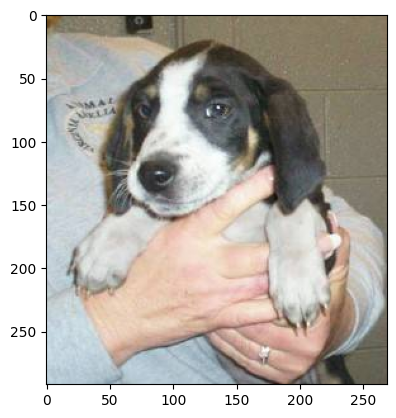

In [ ]:
#@title Quick model check!
# load and prepare the image
def load_image(img_path):
  image = imread(img_path)
  pyplot.imshow(image)

	# now convert to array
def convert_image(img_path, reduced_size, rescale):
  photo = load_img(img_path,  target_size=reduced_size) #load image
  photo = img_to_array(photo) #convert to numpy array
  return asarray(photo/rescale)

# load an image and predict the class
def predict_image(model, img_path, reduced_size, rescale):
  # load the image
  load_image(img_path)
  # load model
  img = np.array([convert_image(img_path, reduced_size, rescale )])
  print(img.shape)
  # predict the class
  result = model.predict(img,verbose = True)
  print('Predicted probability for a dog:', result[0])

img_path =  dataset_path + '/test/dogs/dog.10.jpg' #dog.10
predict_image(CNN, img_path, (64,64), rescale)

## ROC and AUC
Once we have predictions for both train and test dataset, we can quantify the model performances by calculating the ROC curve (true positive rate vs false positive rate for each value of a sliding cut on the network predictions).\
Another metric useful to understand the power of classification is the Area Under Curve (AUC): it is litterally the calculated area under the ROC curve (between 0 and 1 since axis are normalized).\
For an ideal classificator there are no false positives or negatives, therefore the ideal ROC curve would be a rectangular with true positives fraction=1 and false positive fraction= 0 and the correponding AUC is 1.\
The casual choice leads to an AUC = 0.5. Intermediate (real) cases are between 0.5 and 1 (https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg).

ROC AUC - Test                      0.834                    
ROC AUC - Train                     1.000                    


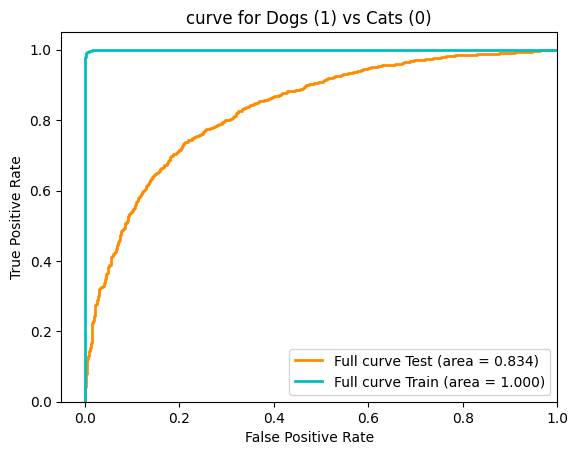

<Figure size 640x480 with 0 Axes>

In [ ]:
#draw roc curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr_test, tpr_test, thresholds_test = roc_curve(labels_test, ypred_test)
roc_auc_test = auc(fpr_test, tpr_test)
print ('{:<35} {:<25.3f}'.format('ROC AUC - Test',roc_auc_test))

fpr_train, tpr_train, thresholds_train = roc_curve(labels_train, ypred_train)
roc_auc_train = auc(fpr_train, tpr_train)
print ('{:<35} {:<25.3f}'.format('ROC AUC - Train',roc_auc_train))

pyplot.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Full curve Test (area = %0.3f)' % roc_auc_test)
pyplot.plot(fpr_train, tpr_train, color='c', lw=2, label='Full curve Train (area = %0.3f)' % roc_auc_train)
pyplot.plot([0, 0], [1, 1], color='navy', lw=2, linestyle='--')
pyplot.xlim([-0.05, 1.0])
pyplot.ylim([0.0, 1.05])
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
pyplot.title('curve for Dogs (1) vs Cats (0)')
pyplot.legend(loc="lower right")
pyplot.show()
pyplot.clf()



## Confusion matrix

By comparing ROC curves between train and test we can have an overview of the overfitting situation: if the model has been too opimized on the train dataset its performances will be worse on test dataset, resulting in a low test AUC with respect to the train one.\
We can also decide to put a threshold on the output of the network at 0.5, defining as dogs images with output>0.5 (probability of belonging to class 1 >0.5) and cats otherwise, and calculate the confusion matrix.

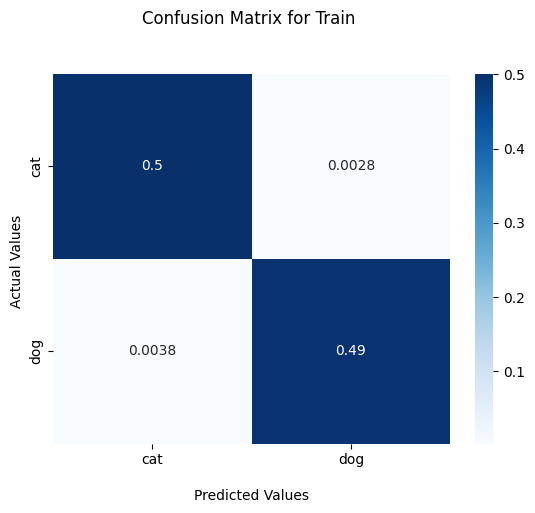

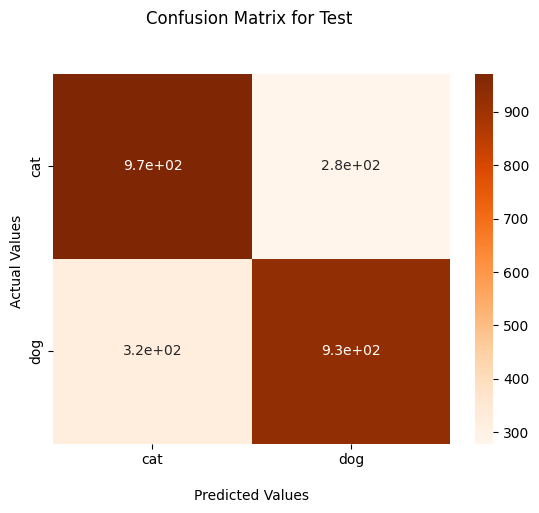

<Figure size 640x480 with 0 Axes>

In [ ]:

#print confusion matrix both for training and for test
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix both for test and training

cf_matrix_train = confusion_matrix(labels_train, np.where(ypred_train > 0.5, 1,0))
ax = sns.heatmap(cf_matrix_train/np.sum(cf_matrix_train), annot=True, cmap='Blues')

ax.set_title('Confusion Matrix for Train \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['cat', 'dog'])
ax.yaxis.set_ticklabels(['cat', 'dog'])

## Display the visualization of the Confusion Matrix.
pyplot.show()
pyplot.clf()


cf_matrix_test = confusion_matrix(labels_test, np.where(ypred_test > 0.5, 1,0))
ax = sns.heatmap(cf_matrix_test, annot=True, cmap='Oranges')

ax.set_title('Confusion Matrix for Test \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels -
ax.xaxis.set_ticklabels(['cat', 'dog'])
ax.yaxis.set_ticklabels(['cat', 'dog'])

## Display the visualization of the Confusion Matrix.
pyplot.show()
pyplot.clf()


From losses, accuracies and ROC curves it seems that our model is still underfitted.\
We are going to try to improve it in few sections, but first let's try to better understand what's going on within our model

# 4) Model Improvements

In order to avoid the underfitting we can try to do several things:

1.   Increase the number of training epochs and/or increase the batch size
2.   Add convolutional+maxpooling layers

> (You can use parts of codes already written by copying below and modifying them or start from scratch)

After having done 1) and 2) you may have obtained the opposite problem: overfitting. If this is your case you can thing to:
3.  add a regularization layer: **the Dropout layer**.\
 It randomly drops connections between layers and the percentage of broken links is set as a layer parameter (rate).\
It is inserted between the output of a maxpool layer and the next convolutional layer (do not drop connections between convolutional layers and maxpool, if not the maxpool is not correctly calculated!) or between dense layers.\
It helps to avoid to overspecialize the model on the training dataset.\
The droput is not applied on validation dataset but only on training, when weights are updated.\
It can be inserted in the following way:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
model.add(Dropout(rate=YOUR_RATE))
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Let's try also to change the rate of dropped connections and see what happens.

You can also
4.   Change the filter size (for istance (5x5 instead of 3x3))
5.   Change the number of filters
6. You can plot again feature maps with your new model to understand figure learning

Now it's your turn to play with CNNs!


## **Let's see who will reach the highest accuracy on Test dataset!**


Opening a pre-fitted model

In [ ]:
from keras.models import Sequential,Model,load_model
model_path = dataset_path + 'best_model.h5'
best_model = load_model(model_path, compile=True)

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


ValueError: Invalid value for argument `reduction`. Expected one of {None, 'sum', 'sum_over_batch_size', 'none'}. Received: reduction=auto

In [ ]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 8)         392       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 8)         0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 8)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        2064      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 16, 16, 16)       

In [ ]:
# evaluate the model on test dataset
#best_model.compile()
_, acc_best = best_model.evaluate(photos_test/rescale, labels_test, batch_size=64, verbose=1)

print('Accuracy on test dataset: %.3f' % acc_best)


40/40 [==============================] - 1s 7ms/step - loss: 0.3836 - accuracy: 0.8240
Accuracy on test dataset: 0.824


#5) Opening the black box

It could be very instructive understanding how filters and features operate inside our 'black box'. Both filters and feature maps can be visualized.

## Filters visualization

Let's try to understand how filters work. We can visualize it by getting weights for each filter in each convolutional layer.

conv2d (3, 3, 3, 6)
6


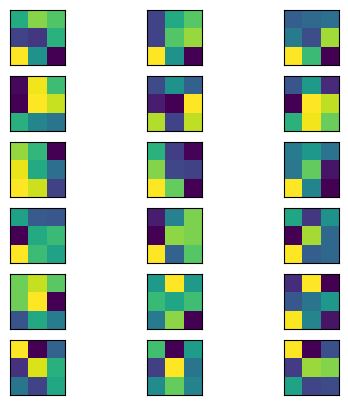

conv2d_1 (3, 3, 6, 12)
12


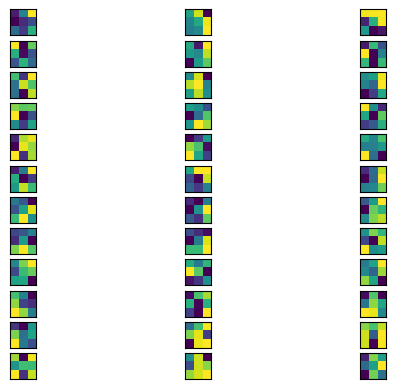

In [ ]:
#Visualizing the filters in order
pyplot.figure(figsize=(5,5))
for layer in CNN.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, weights.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(weights.shape[3])
        filter_cnt=1
        #plotting all the filters
        for i in range(filters.shape[3]):

            #get the filters
            filt=filters[:,:,:, i]
            #print(filt)
            #print('-----------')
            #plotting ecah channel
            for j in range(filters.shape[0]):
                #pyplot.figure( figsize=(5, 5) )
                #f = plt.figure(figsize=(10,10))
                ax= pyplot.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                pyplot.imshow(filt[:,:, j])
                #print(filt[:,:, j])
                #print('********************')
                filter_cnt+=1
        pyplot.show()




The dark squares indicate small  weights and the light squares represent large or excitatory weights.

## Features visualization

We can visualize feature maps obtained from applied filters to input images. They can give an insight into the internal representation that a model has of a specific input.

Feature maps are generated by applying Filters or Feature detectors to the input image or the feature map output of the prior layers.

Function defined below can help to reach this goal. The main steps are:



1.   Define a new model, based on previous one, but we will manage all intermediate layer representation

2. Load the input image,  convert the image to NumPy array an rearrange it
3.  Run the input image through the visualization model to obtain all
intermediate representations for the input image
4. Plot Feature map for all convolutionale and max pool layers





In [ ]:
from tensorflow.keras.models import Model

def plot_features(theModel, img_path):

  # Define a new Model
  # Output= intermediate representations for all layers in the
  # previous model after the first.
  successive_outputs = [layer.output for layer in theModel.layers[1:]]

  #our model has the same input as previous model
  visualization_model = Model(inputs = theModel.input, outputs = successive_outputs)

  #Load image
  image = imread(img_path)
  pyplot.imshow(image)

  img = load_img(img_path, target_size=(64,64))

  # Convert image to Array
  x   = img_to_array(img)
  x  = x.reshape((1,) + x.shape)

  # Rescale by 1/255
  x /= 255

  # Predict our feature maps over image
  successive_feature_maps = visualization_model.predict(x,verbose = True, batch_size=64)

  # Let's start our loop over layers
  # Retrieve are the names of the layers, so can have them as part of our plot

  layer_names = [layer.name for layer in theModel.layers]
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(layer_name)
    print(feature_map.shape, len(feature_map.shape))

    if len(feature_map.shape) == 4: #skipping non conv and max pool layers

      # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

      n_features = feature_map.shape[-1]  # number of features in the feature map
      size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

      # Create a matrix of images to plot together
      display_grid = np.zeros((size, size * n_features))

      print(n_features)
      # Postprocess the feature
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')

        #Put each filter into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x

      # Display the grid
      scale = 20. / n_features
      pyplot.figure( figsize=(scale * n_features, scale) )
      pyplot.title ( layer_name )
      pyplot.grid  ( False )

      pyplot.imshow( display_grid, aspect='auto', cmap='viridis' )



1/1 [==============================] - 0s 101ms/step
conv2d
(1, 32, 32, 6) 4
6
max_pooling2d
(1, 32, 32, 12) 4
12
conv2d_1
(1, 16, 16, 12) 4
12
max_pooling2d_1
(1, 3072) 2
flatten_layer
(1, 3072) 2
dense
(1, 1) 2


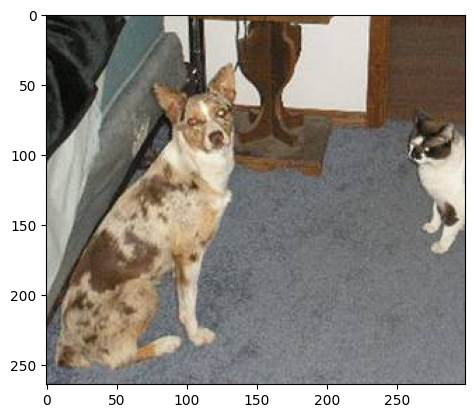

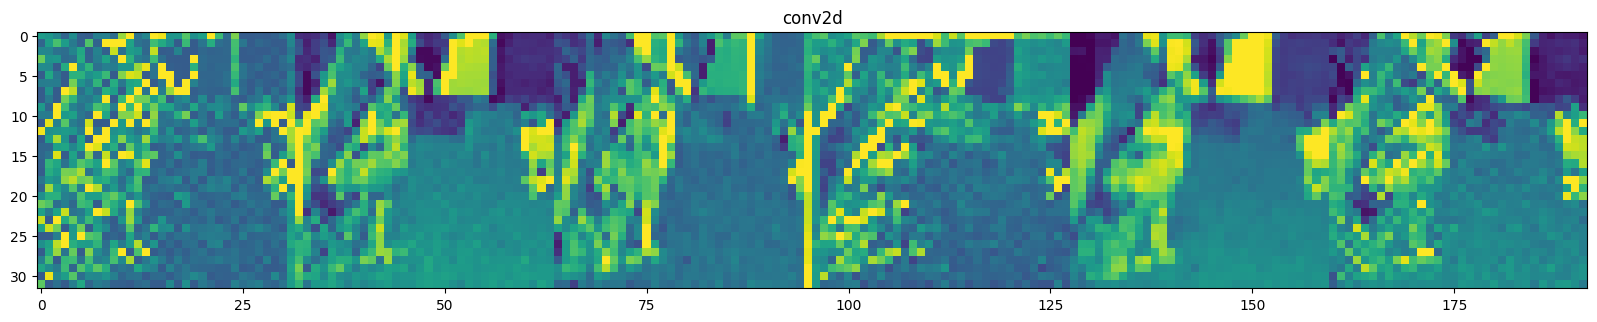

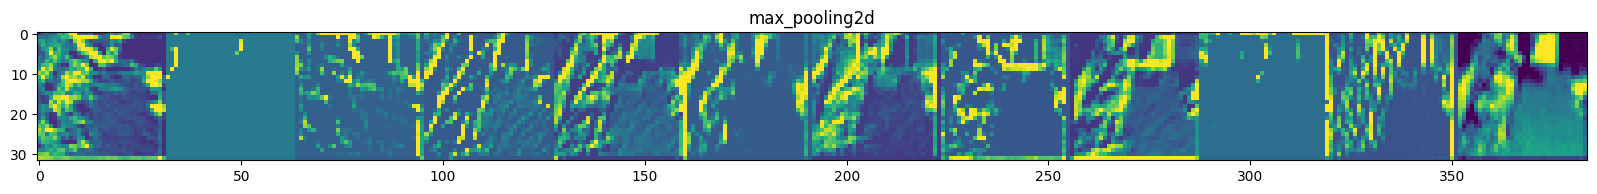

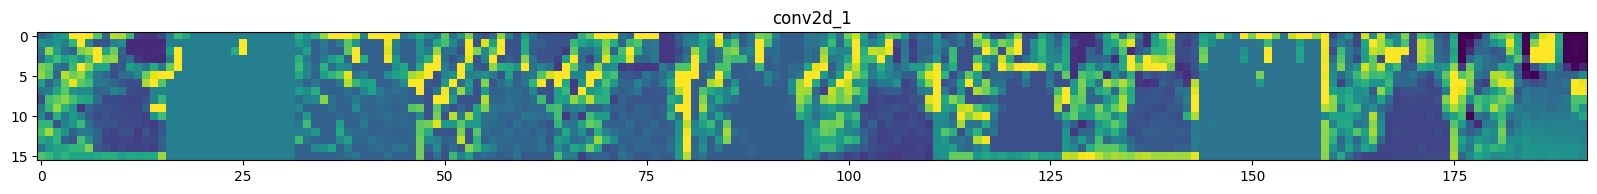

In [ ]:
#Let's test it!
img_path = dataset_path + 'test/dogs/dog.7.jpg'
plot_features(CNN, img_path)

1/1 [==============================] - 0s 291ms/step
conv2d_6
(1, 32, 32, 8) 4
8
max_pooling2d_6
(1, 32, 32, 8) 4
8
dropout_10
(1, 32, 32, 16) 4
16
conv2d_7
(1, 16, 16, 16) 4
16
max_pooling2d_7
(1, 16, 16, 16) 4
16
dropout_11
(1, 16, 16, 32) 4
32
conv2d_8
(1, 5, 5, 32) 4
32
max_pooling2d_8
(1, 5, 5, 32) 4
32
dropout_12
(1, 800) 2
flatten_layer
(1, 800) 2
dropout_13
(1, 800) 2
dense_6
(1, 800) 2
dropout_14
(1, 1200) 2
dense_7
(1, 1) 2


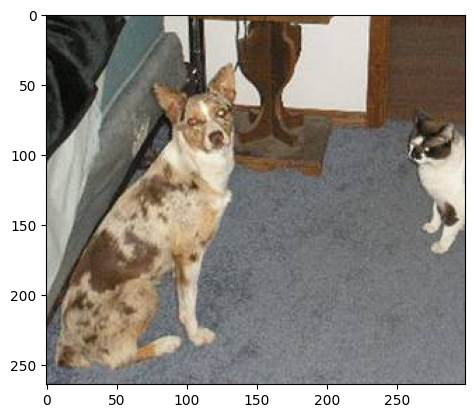

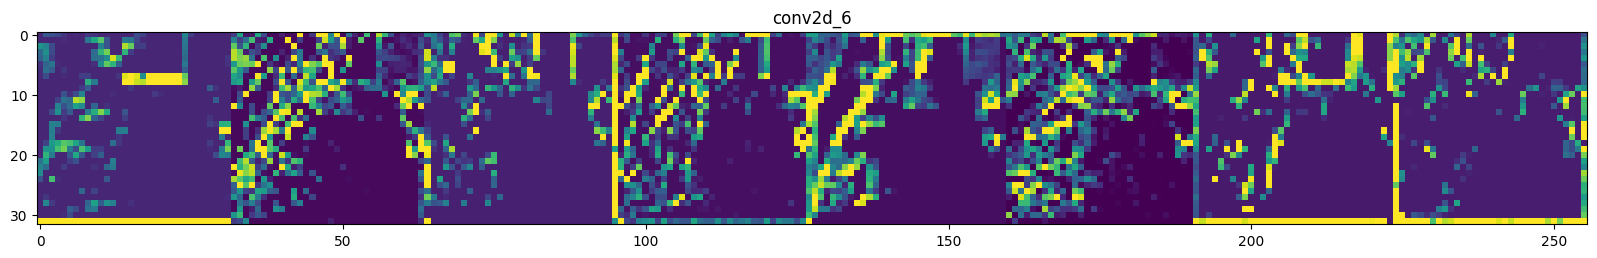

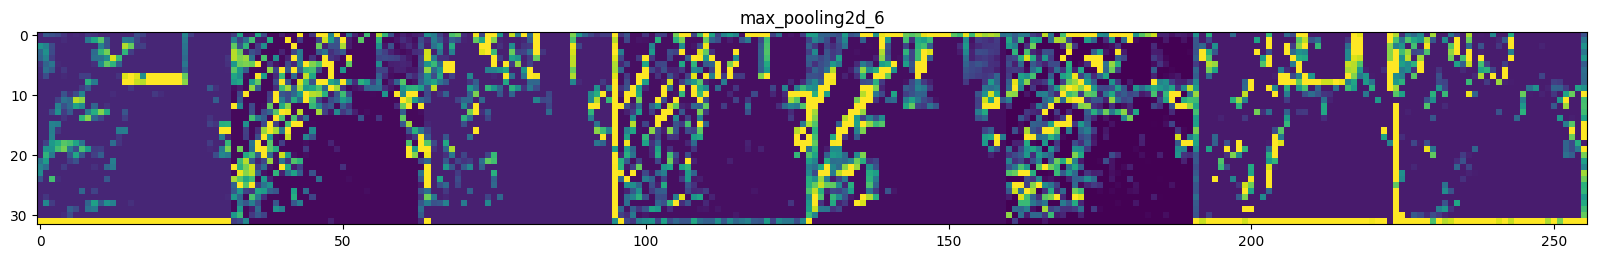

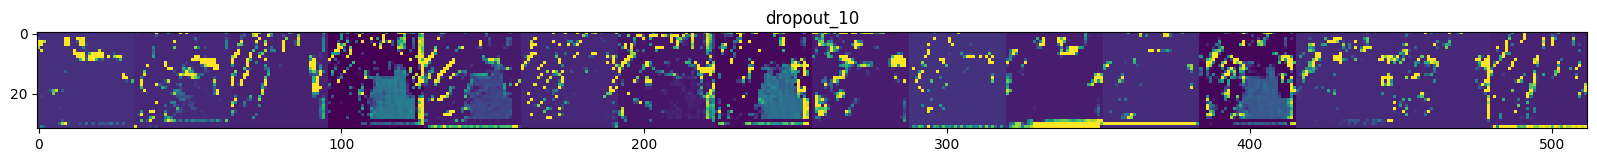

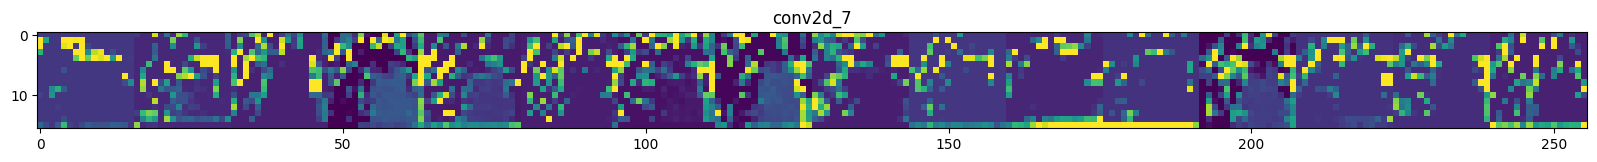

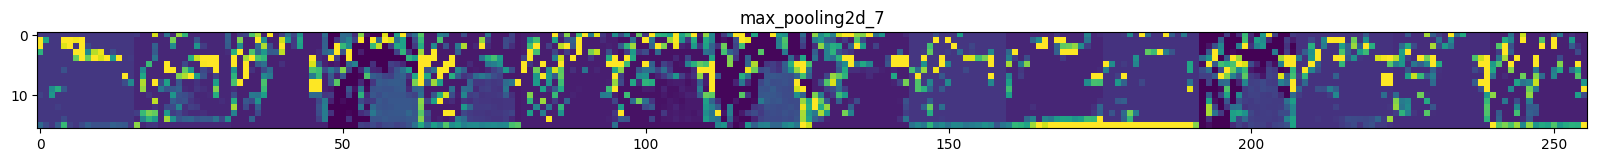

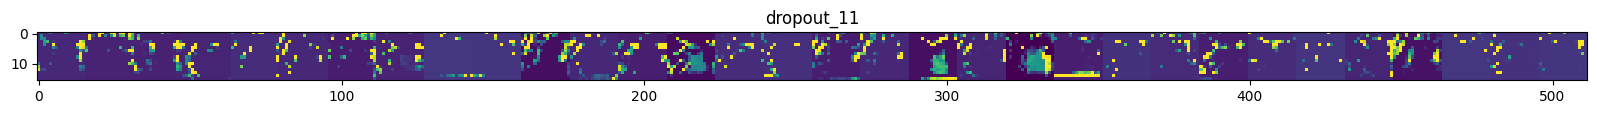

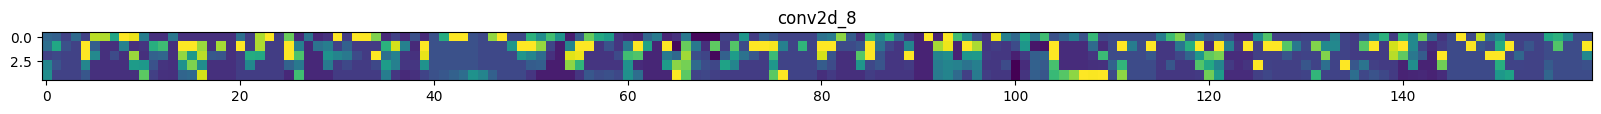

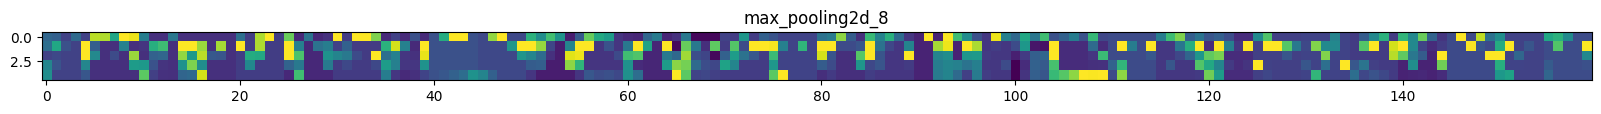

In [ ]:
plot_features(best_model, img_path)

# 6) Data augmentation

Data augmentation is a set of techniques for dealing with cases
where the training data is limited. It allows to artificially modify images
leading to a  boost in the performance of  learning model by reducing
overfitting. It consists in a set of transformations such as cropping parts of an image, flipping, changing the contrast, brightness, and saturation.

We will use [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), a class of keras and apply the following changes:


*   rescale by a given factor (1/255 will put all pixel values in range [0,1])
*   degree range for random rotations
*   shift width and height of a given fraction
*  Randomly flip inputs horizontally/vertically
*  zoom a figure

We will not redo training with data augmentation since is time expensive, and available resources in Google Colab are limited.



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# data augmentation
batch_size = 128
IMG_HEIGHT = 64
IMG_WIDTH = 64
TRAIN_PATH = dataset_path + '/train/'


train_image_generator = ImageDataGenerator(
                                                rescale=1./255,
                                                rotation_range=45,
                                                width_shift_range=.15,
                                                height_shift_range=.15,
                                                horizontal_flip=True,
                                                zoom_range=0.3

                                            ) # Generator for our training data






```flow_from_directory()``` will take the data from the specified path and generates batches of augmented normalized data.

In [ ]:

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=TRAIN_PATH,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')



Found 16875 images belonging to 2 classes.


Labeling is automatic, let's print it

In [ ]:
train_data_gen.class_indices

{'cats': 0, 'dogs': 1}

We can plot a figure and its changes.

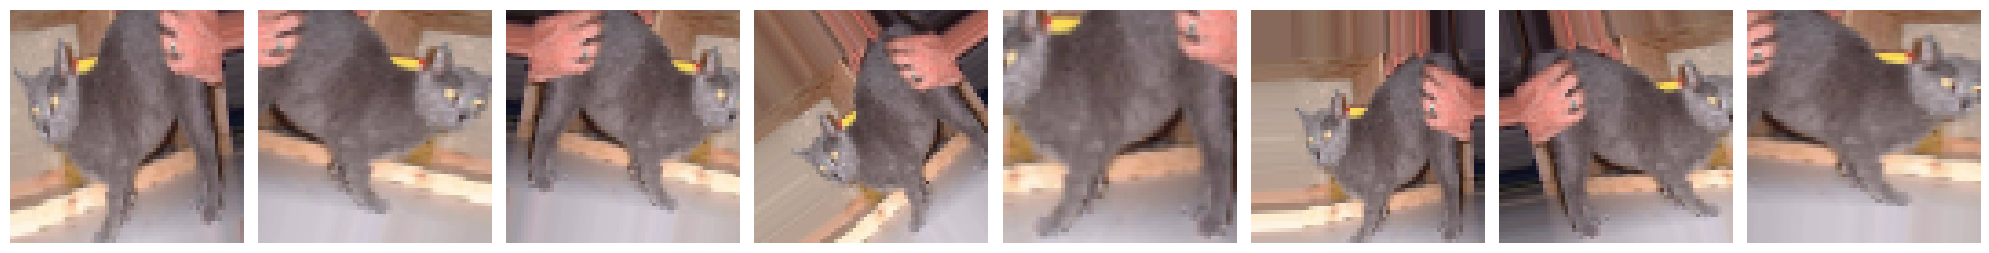

In [ ]:
# Plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = pyplot.subplots(1, 8, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    pyplot.tight_layout()
    pyplot.show()

augmented_images = [train_data_gen[0][0][0] for i in range(8)]
plotImages(augmented_images)

Now, we should create the same for validation and test dataset

In [ ]:
VAL_PATH = dataset_path + '/validation/'
TEST_PATH = dataset_path + '/test/'

val_image_generator = ImageDataGenerator(
                                                rescale=1./255,

                                            ) # Generator for our validation data

val_data_gen = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=VAL_PATH,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      class_mode='binary')

test_image_generator = ImageDataGenerator(
                                                rescale=1./255,


                                            ) # Generator for our test data

test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=TEST_PATH,
                                                     shuffle = False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode=None)


Found 5625 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:

CNN_DA = define_model(input_shape)

from tensorflow.keras.callbacks import EarlyStopping
callback_DA = [EarlyStopping(verbose=True, patience=10, monitor='val_loss')]


# fit the model
n_epochs = 3

history_DA = CNN_DA.fit(
      train_data_gen,
      epochs=n_epochs,
      validation_data=val_data_gen,
      callbacks=callback_DA,
      verbose = 1
    )
#the output is a history object that contains all information collected during training. We store it to plot network performances during training


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 6)         168       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 12)        660       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 12)        0         
 g2D)                                                            
                                                                 
 flatten_layer (Flatten)     (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 3072)             

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7e76acd71fd0>